In [1]:
import control
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.integrate import odeint

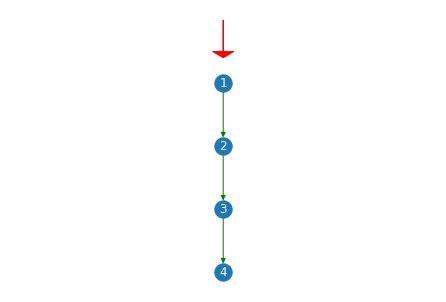

In [2]:
n = 4
G = nx.DiGraph()
G.add_edges_from([(i, i+1) for i in range(1, n)])

pos={i + 1: np.array([0, -i]) for i in range(n)}
nx.draw(G, pos, with_labels=True, font_color="white", edge_color="g")
plt.arrow(0, 1, 0, -0.5, head_width=0.0005, head_length=0.1, width=0, color="r")
plt.show()

$\frac{d}{dt}x = Ax + Bu$  
$u = -Kx$  
$\frac{d}{dt}x = (A - BK)x$  
$x_{t+1}- x_T = (A - BK)(x_{t+1} - x_{T})$  
 - $x_{t} = [x_{t}^1,x_{t}^2, ... ,x_{t}^n]$ state at time $t$  
 - $x_{0}$ initial state
 - $x_{T}$ desired state at time $T$

$A = \begin{bmatrix}
0 & 0 & 0 & 0\\
1 & 0 & 0 & 0\\
0 & 1 & 0 & 0\\
0 & 0 & 1 & 0
\end{bmatrix} 
B = \begin{bmatrix}
1\\
0\\
0\\
0
\end{bmatrix}$

## _Dummy_ solution
Without any advance control theory, we can get a network defiend by an adjacency matrix $A$ and controlers defined by a matrix $B$ into any state. The signal sent by the $u$ propagates through the network, in other using $u_{t} = x_{t+i}^i$ we can _cook_ any state we wish. 

## _Place_ $A-BK$ into some non-positive eigen values

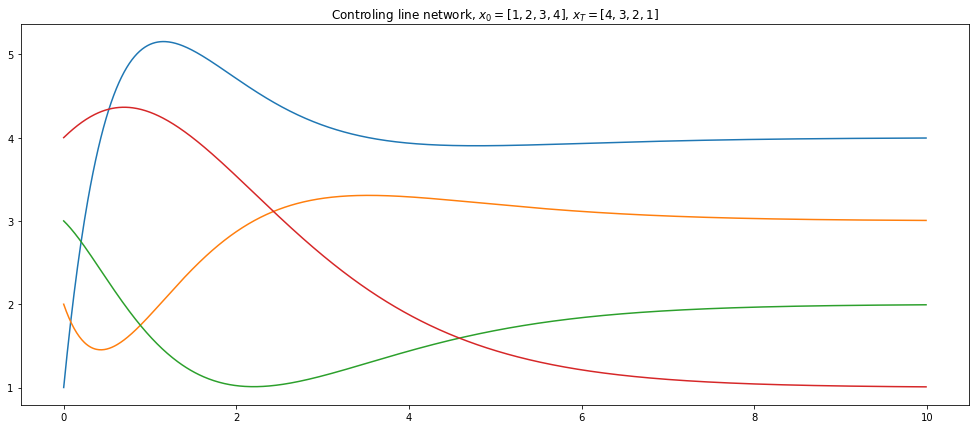

In [3]:
# Some non-positive eigen values to "place" matrix (A-BK) to
eigs = np.array([-1, -1.1, -1.2, -1.3])

A = np.array([[0, 0, 0, 0], [1, 0, 0, 0], [0, 1, 0, 0],[0, 0, 1, 0]])
B = np.array([[1], [0], [0], [0]])
K = control.place(A, B, eigs)

x0 = np.array([1, 2, 3, 4])
xT = np.array([4, 3, 2, 1])

def line_network(x, t, K):
    x_diff = (x - xT)
    u = np.dot(-K, x_diff)
    return np.dot(A, x_diff) + np.dot(B, u)

t = np.arange(0, 10, 0.01)
solution = odeint(line_network, x0, t, args=(K, ))

plt.figure(figsize=(17, 7))
plt.title(f"Controling line network, $x_0={list(x0)}$, $x_T={list(xT)}$")
plt.plot(t, solution)
plt.show()

## Kalman filter

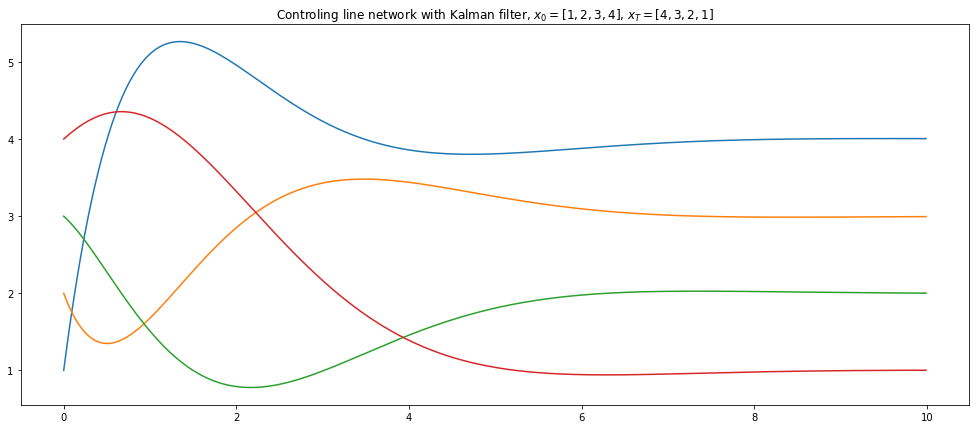

In [4]:
# Design LQR controller
Q = np.eye(n)
R = .0001
K_hat, S, E = control.lqr(A, B, Q, R)

t = np.arange(0, 10, 0.01)
solution = odeint(line_network, x0, t, args=(K_hat, ))

plt.figure(figsize=(17, 7))
plt.title(f"Controling line network with Kalman filter, $x_0={list(x0)}$, $x_T={list(xT)}$")
plt.plot(t, solution)
plt.show()

In [21]:
def pentanary(state: np.array) -> int:
    num = "".join([str(int(a)) for a in state])
    return int(num, 5)

assert pentanary(np.array([1,2,3,4])) == 194

$Q(S_t, A_t) \leftarrow Q(S_t, A_t) + \alpha [R_{t+1} + \gamma max_{a} Q(S_{t+1}, a) - Q(S_t, A_t)]$

In [44]:
q = {}

epsilon = 0.01
gamma = 0.999
alpha = 0.5

desired_state_pentanary = pentanary(xT)

def episode(max_iter=20, halt=False):
    def model(_s, _a):
        return (np.dot(A, _s) + np.dot(B.T, _a))[0]
        
    state = x0
    action = 0
    history = [state]
    for _ in range(max_iter):
        state_pentanary = pentanary(state)
        
        if np.random.rand() < epsilon:
            # Explore strategy
            best_a = np.random.randint(0, 5)
            
        else:
            # Exploit strategy
            q_max = -1
            best_a = -1
            for a in range(0, 5):
                temp_state = model(state, a)
                temp_state_pentanary = pentanary(temp_state)
                if q.get((temp_state_pentanary, a), 0.1) > q_max:
                    q_max = q.get((temp_state_pentanary, a), 0.01)
                    best_a = a
            
        temp_state = model(state, best_a)
        temp_state_pentanary = pentanary(temp_state)
        q_max = q.get((temp_state_pentanary, best_a), 0.01)
        
        reward = (temp_state_pentanary == desired_state_pentanary) * 1
        q_current = q.get((state_pentanary, action), 0.01)
        q[(state_pentanary, action)] = min(q_current + alpha * (reward + gamma * q_max - q_current), 1)
        
        state = temp_state
        action = best_a
        history.append(state)
        if reward and halt:
            return history
        
    return history

In [45]:
for e in range(10000):
    episode()

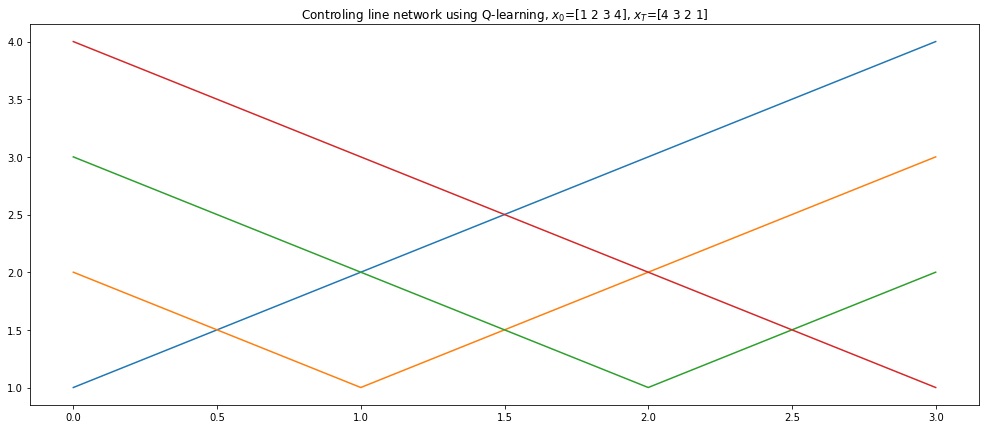

In [51]:
plt.figure(figsize=(17, 7))
plt.title(f"Controling line network using Q-learning, $x_0$={x0}, $x_T$={xT}")
plt.plot(episode(halt=True))
plt.show()